<a href="https://colab.research.google.com/github/sathvikb007/Image-Clustering-with-Autoencoders/blob/branch1/1_simpleAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder**

An autoencoderis a neural network that is trained to attempt to copy its input to its output. Internally, it has a hidden layer that describes a code used torepresent the input. The network may be viewed as consisting of two parts: an encoder function h=f(x) and a decoder that produces a reconstruction r=g(h). If an autoencoder succeeds in simply learning to set g(f(x)) =x everywhere, then it is not especially useful. Instead, it is designed to learn useful properties of the dataset.



![alt text](https://www.compthree.com/images/blog/ae/ae.png)

# ***Simple Autoencoder***

The model below emulates a vanilla autoencoder with one hidden layer containing 49 nodes. Therefore the original images of dimensions of 
28 x 28 are reduced to
7 x 7. These image embeddings are then used for clustering the dataset.


![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png)

In [1]:
#Importing the required libraries

from keras.callbacks import Callback
from keras.layers import *
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import regularizers
from keras import optimizers
from keras.optimizers import RMSprop
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np
import tensorflow as tf


Using TensorFlow backend.


In [0]:
#Loading the fashion MNIST dataset

fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
y_train.shape

(60000,)

In [4]:
#Normalizing the data

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
#size of our encoded representations
encoding_dim = 49 

input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
#create the encoder model
encoder = Model(input_img, encoded)

In [0]:
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [8]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[history])






Train on 60000 samples, validate on 10000 samples
Epoch 1/150





60000/60000 [==============================] - 2s 39us/step - loss: 0.1146 - val_loss: 0.0894
Epoch 2/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.0813 - val_loss: 0.0722
Epoch 3/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.0668 - val_loss: 0.0615
Epoch 4/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.0591 - val_loss: 0.0565
Epoch 5/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.0551 - val_loss: 0.0533
Epoch 6/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.0521 - val_loss: 0.0505
Epoch 7/150
60000/60000 [==============================] - 1s 19us/step - loss: 0.0494 - val_loss: 0.0479
Epoch 8/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.0469 - val_loss: 0.0455
Epoch 9/150
60000/60000 [==============================] - 1s 19us/step - loss: 0.0446 - val_l

Text(0, 0.5, 'mean squared error')

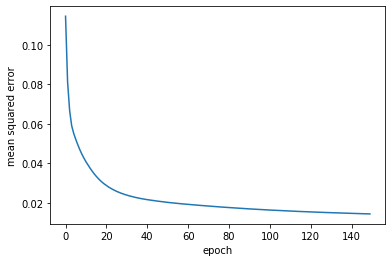

In [10]:
#To plot loss vs epoch

plt.plot(list(range(len(history.losses))), history.losses)
plt.xlabel('epoch')
plt.ylabel('mean squared error')

In [0]:
SAE_encoded_imgs_train = encoder.predict(x_train)                   #contains all the encoded images of the training set
SAE_decoded_imgs_train = decoder.predict(SAE_encoded_imgs_train)    #contains all the reconstructed images of the training set

SAE_encoded_imgs_test = encoder.predict(x_test)                     #contains all the encoded images of the test set
SAE_decoded_imgs_test = decoder.predict(SAE_encoded_imgs_test)      #contains all the reconstructed images of the test set

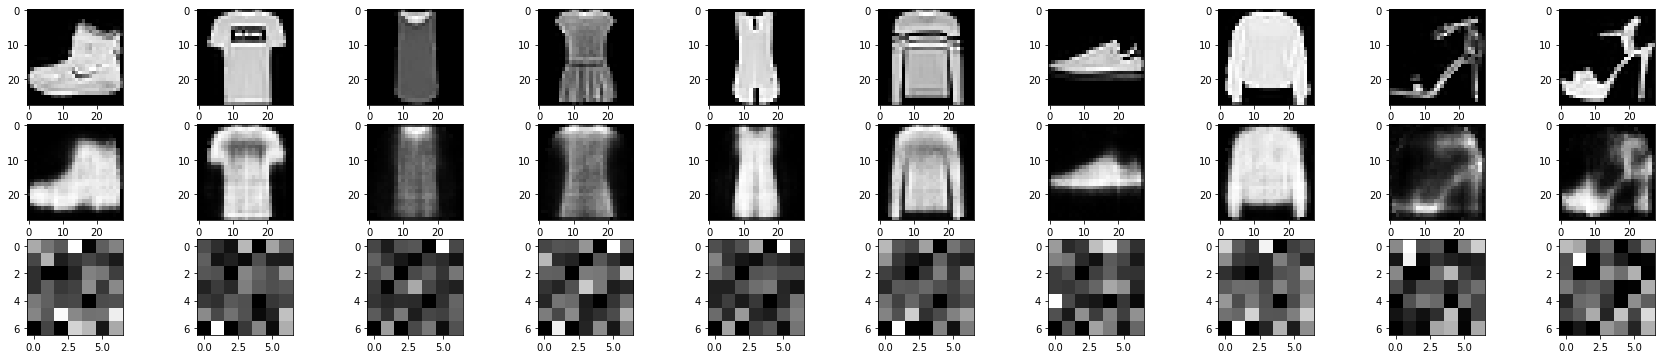

In [12]:
# To display original image , reconstructed image, and latent representation of each image in a lower dimension

n = 10
plt.figure(figsize=(30,6))
for i in range(n):

    # display original

    ax = plt.subplot(3, n, i + 1)
    plt.gray()
    plt.imshow(x_train[i].reshape(28, 28))
    
    

    # display reconstruction of the imgae

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(SAE_decoded_imgs_train[i].reshape(28, 28))

    #display latent representation
    
    ax = plt.subplot(3, n, i+1+ n*2)
    plt.imshow(SAE_encoded_imgs_train[i].reshape(7,7))
   
plt.show()

As seen in the second row, most of the original details of the original image have been lost. 

In [0]:
# Standardizing the encoded data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(SAE_encoded_imgs_train)
X_test  = sc.transform(SAE_encoded_imgs_test)

In [0]:
#Clustering the data into 10 classes with the encoded data

from sklearn.cluster import KMeans
SAEkmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

In [0]:
yPredtrain = SAEkmeans.predict(X_train)
yPredtest = SAEkmeans.predict(X_test)

In [16]:
from sklearn import metrics
print(metrics.adjusted_rand_score(y_train.reshape(60000,).tolist(), yPredtrain.tolist()))
print(metrics.adjusted_rand_score(y_test.reshape(10000,).tolist(), yPredtest.tolist()))

0.30932005605313123
0.30616342938182095


The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. 

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical.

ARI is useful when the true labels for the clusters are given ( here, y_train and y_test are the true labels ) ARI does not depend on the actual value of the true labels given but the similarity between the predicted and true values.

In [17]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y_train, yPredtrain))
print(normalized_mutual_info_score(y_test, yPredtest))

0.4518501378209331
0.4472549638841731


Mutual information is a symmetric measure for the degree of dependency between the clustering and the manual classification. It is based on the notion of cluster purity pi, which measures the quality of a single cluster Ci, the largest number of objects in cluster Ci which Ci has in common with a manual class Mj, having compared Ci to all manual classes in M.

The formula for NMI is:



![NMI](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/data-mining-an-introduction-69-638.jpg)